# Collection APIs & Machine Learning - A Brief Look
*By Andrés De los Ríos -  26/02/2019*

MSL2030: Assignment 1

## Table of Contents
1. [Intro - Data & Museums: Why Machine Learning?](#1)
2. [Tools](#2)
3. [APIs - Collecting Data](#3)
4. [Exploring the Data](#4)
5. [Preprocessing](#5)
6. [Feature Extraction](#6)
7. [Tf-idf](#7)
8. [Naive Bayes + Tf-idf](#8)
9. [Random Forest + Tf-idf](#9)
10. [Comparing Results & Improving the Model](#10)
11. [Conclusion](#11)



## 1. Introduction <a name="1"></a>

### Data & Museums: Why Machine Learning?

Machine learning has proven to be a paradoxical tool in the modern workforce: despite its complex mathematical foundations, [companies and employees from all sectors are quickly integrating machine learning into new business strategies or products.][1] The world of art and museums has not been an exception. 

In the private sector, artificial intelligence (AI) has defied our definition of creativity and authorship by [producing artworks worth of close half a million dollars.][2] 

Museums have also implemented AI to create new connections amongst their objects. For example, just last year the Barnes Foundation incorporated computer vision to [their public collections website][3] so that users can browse artworks according to visual aspects such as linear composition, color, and spatial arrangement. (In a way, the new set-up [further manifests the museum's challenge][4] towards any predetermined art-historical groupings that may be imposed to audiences during their visit.)

Similarly, the Baseball Hall of Fame [used Python and machine learning scripts to automatically tag their collection's online content][5], thereby bringing to the fore pieces and stories that had been previously kept in the dark. 

To get staff started on the endless possibilities of machine learning, this tutorial offer an introductory glimpse into the processes of collections data acquisition, processing and analysis through two prominent classification models. 

### Supervised Machine Learning: Clasification 

Before coding, we need to set some vocabulary straight:

* **Supervised Machine Learning** are any algorithms that use patterns previously-labelled data and its characteristics or features to tag unlabeled entries.  

* **Classification** is the technique of determining a data entry's class/label/tag based on one or more independent variables. 

For the present excercise, we will use two different classification models: **Naive Bayes** and **Random Forest** - explained below. In our case, the object entries will be our records; the content of their label texts will be processed as independent variables; and their place of origin will be the predicted tags. 

Properly used, these tools can help collections staff automatically classify their vast holdings. Furthermore, the data processes and machine learning models could also be used by IT, Education and Interpretation Departments to challenge traditional perspectives of their institution's collection. 

[1]: https://towardsdatascience.com/essential-data-skills-supply-and-demand-on-the-job-market-4f7dffa23b70
[2]: https://www.christies.com/features/A-collaboration-between-two-artists-one-human-one-a-machine-9332-1.aspx
[3]: https://collection.barnesfoundation.org
[4]: https://medium.com/barnes-foundation/rethinking-the-museum-collection-online-e3b864d8bb39
[5]: https://blog.cogapp.com/using-artificial-intelligence-to-enhance-user-experience-201370248b94

## 2. Tools <a name="2"></a>

### Tutorial Requirements
* Basic knowledge of Python - see [CognitiveClass.ai's "Python 101" course][1] or [DataCamp.com's Data Analyst tutorials][2] for more introductory material on using Python to extract and manipulate data. 
* Python Integrated Development Environment (IDE) - for example Jupyter Notebooks, Visual Studio Code or Sypder. 
* Working collections API - in this excercise, we will use the [Rijksmuseum's API][3]; see the linked documentation for more informatin on the API's request and data structure. 
* A collections dataset - for best results, ensure each record has at least one associated label/descriptive text and categorical feature (for example a location, category, or type tag). 
[1]:  https://cognitiveclass.ai/courses/python-for-data-science/
[2]: https://www.datacamp.com/tracks/data-analyst-with-python
[3]: http://rijksmuseum.github.io

### Python Modules and Libraries
To run our code, we will need to download and import the following modules into our Python environment: 



In [168]:
import json #to easily navigate json data objects extracted from the Rijksmuseum's API. 
import matplotlib.pyplot as plt #to visually explore our dataset.
import pandas as pd #to manipulate our data as a single dataframe.
import re #to clean the strings in our dataset through regular expressions.
import requests #to make the HTTP requests needed to extract the data we want from the Rijksmuseum's API.

from sklearn.feature_extraction.text import TfidfVectorizer #to convert our our label text into a matrix of features
from sklearn.naive_bayes import MultinomialNB #multinomnial Naive Bayes classifier 
from sklearn.ensemble import RandomForestClassifier #Random Forest classifier
from sklearn.model_selection import train_test_split #to quickly split our data into random train and test subsets. 
from sklearn.metrics import classification_report, accuracy_score #to easily represent and compare the accuracy of our models. 
from sklearn import preprocessing #to change raw features into suitable representations for our models 
from nltk.corpus import stopwords #a compilation of English stopwords to filter out irrelevant features for our classification

## 3. APIs - Collecting Data <a name="3"></a>

**Application Programming Interface (API)**: a set of protocols and commands to "communicate" with a particular program. In the case of online collections, the API takes the form of a url address with several optional parameters that dictate how your query will search the collection and the output of said search. 

Some examples of online collection APIs include:
- [Metropolitan Museum of Art][1]
- [Cooper-Hewitt Smithsonian Design Museum][2]
- [Harvard Art Museums][3]
- [Victoria & Albert Museum][4]


### Constants
Before making any requests, we need to initialize the constants we will use throughout the tutorial. These are any labels, columns, keys or object information that will not change even after processing the code's commands. 

These constants often depend on each museum's collection metadata or each API's formatting, so look carefully into your institution's documentation to use the proper labels and keys. 

In the example below, we have selected a number of object features drawn from the Rijksmuseum API documentation; these will later serve as our dataframe's columns. Likewise, we have obtained an API key from the museum that validates our request for collections information. 

[1]: https://metmuseum.github.io
[2]: https://collection.cooperhewitt.org/api/
[3]: https://github.com/harvardartmuseums/api-docs
[4]: http://collections.vam.ac.uk/information/information_apigettingstarted

In [169]:
#Object feature categories to extract from each request; these will later serve as our data frame's columns.
r_columns_db = ['objectNumber', "links", "title", "principalOrFirstMaker", 'longTitle','productionPlaces']

#Unique API key to request data from the Rijksmuseum API - each user needs to solicit their own from the museum. 
r_API = "auGMKu87"

#URL through which we will query data from the Rijksmuseum's API. 
r_path = "https://www.rijksmuseum.nl/api/en/collection/"

### Functions 

Three functions will help us extract data from the Rijksmuseum API: 
1. **r_Search_Works_Display** searches the collection and pulls the unique identifiers (the "objectNumber" feature) and URLs of any artworks on display that relate to our query. 
2. **r_to_DF** creates a data frame from our object listing where each artefact represents a row and the features of the constant r_columns_db represent the dataframe's columns. 
3. **get_Object_Info** queries each object's complete set of records through its unique identifier to populate the dataframe with the column features specified above.

### r_Search_Works_Display

The function first produces a lower-case copy of the query the API will use to search the collections **(1)**. This a common practice when handling text data as it helps standarize how we query information.  

We must then specify the parameters for our query **(2)**:
* "key": our unique key that proves we received permission to query the Rijksmiseum's API.
* "format": format of the query's output. 
* "q": string of text we want the API to search for in the collection's object records; if left blank, the API will just pull information from all objects that are currently on display.
* "ps": number of results per page
* "ondisplay": forces the request to only produce objects that are (or not) on display. 
* "st": describes the category of records where the search will take place. 

*NOTE: these represent only a handful of the Rijksmuseum's API request parameters, for more information on the other options, please see the museum's documentation.*   

The count of first request will tell us the number of objects that match our query; we will then divide this amount by 100 to obtain the number of pages we will need to parse through to collect data on all objects **(3)**

After initializing the dictionary where we will store the object's basic information **(4)**, we will issue a new set of requests - this time, we will specify the page of object listings we want to parse. **(5)** Each page's content is extracted as a json package containing 100 object records. **(6)** In this step, we are looking specifically for the objects' unique identifiers, which will serve as their keys in the dictionary we initialized above; the object's basic information will serve as its key's value in the dictionary **(7)**

Once the code has parsed through all the pages and all the objects, the function returns a full dictionary of data. **(8)**

In [76]:
def r_Search_Works_Display(query):

    #1
    query = query.strip().lower()
    
    #2
    query_params = {'key': r_API, 'format': 'json', 'q': query, 'ps': '100', "ondisplay": "True", "st": "Objects"}
    
    #3
    r_count = requests.get(r_path, params=query_params)
    
    r_pages = (r_count.json()["count"]//100) + 1
    
    #4
    r_works = {}
    
    #5
    while r_pages != 0:
        
        query_params["p"] = str(r_pages)
        
        r_page_request = requests.get(r_path, params=query_params)
        
        #6
        objects = r_page_request.json()
        
        for i in range(len(objects['artObjects'])):
            
            #7
            objectID = objects['artObjects'][i]["objectNumber"]
            
            r_works[objectID] = objects['artObjects'][i]
            
        r_pages -= 1
        
    #8    
    return r_works

### r_To_DF

We must now use a function to change our data dictionary into a dataframe for easy manipulation. **(1)** Including the constant list of features specified above will as a function parameter integrate them into the dataframe as columns. **(2)** (In case we ever need to access an object's web page, we can extract the website's url from the "links" feature.) **(3)**.  

In the end, the function returns a dataframe with objects as rows, object numbers as their unique identifiers and features as columns. **(4)**

In [77]:
def r_To_DF(ObjectData, columns = ""):
    
    #1
    df = pd.DataFrame.from_dict(ObjectData, orient = "index")
    
    #2
    if columns:
        df = df[columns]
    
    #3
    df["url"] = df["links"].apply(lambda x: x["web"])
    
    df = df.drop(columns=['links'])
    
    #4
    return df

### get_Object_Info

To obtain an object's complete record - which includes additional information such as label, media, type, etc. - we need to create a request that includes its unique identifier. **(1)**

We must now travel through each request's resulting json package to pull specific object information. In this case, we have located and extracted each artefact's label text, type, collection category, material and iconographic description. **(2)** These variables are then passed as data to populate each object's row in the dataframe.

In [78]:
def get_Object_Info(row):

    #1
    i = row["objectNumber"]
    
    object_entry = requests.get(r_path + i + "?key=" + r_API+ "&format=json")
    
    #2
    object_label = object_entry.json()["artObject"]["label"]["description"]
    
    object_types = object_entry.json()["artObject"]['objectTypes']
    
    object_collections = object_entry.json()["artObject"]['objectCollection']
    
    object_materials = object_entry.json()["artObject"]['materials']
    
    object_icon_class = object_entry.json()["artObject"]["classification"]['iconClassDescription']
    
    return object_label, object_types, object_collections, object_materials, object_icon_class

### Putting everything together

Now we will process the functions in the appropriate sequence. 

Notice we need to specify how we will label the outputs of function r_get_Object_Info according to the information we pulled from each object's complete record. 

We also had to make use of pandas' **apply** function alongside **zip()** (and it's * operator): with "axis=1", the former will apply the specified function to each row in the dataframe; the latter will pair the new columns with their associated function outputs every time the function runs. **(1)**

Finally, since we will rely on label text for our machine learning analysis, we need to quickly filter out any rows without a label. **(2)**

In [82]:
data = r_Search_Works_Display("")

df = r_To_DF(data, columns=r_columns_db)

#1
df["Label"], df["Type"], df["Collection"], df["Materials"], df["Icons"] = zip(*df.apply(get_Object_Info, axis=1))

#df = pd.read_csv("sample_data_Displayed.csv", encoding = "ISO-8859-1") - for testing purposes only

#2
df = df[df["Label"].notnull()]

# 4. Exploring the Data <a name="4"></a>
Having collected our data, we can use various basic functions to explore the dataset's main features: 
- Using the **head** function we can look at the first five rows of our dataset (or more, if specified); this is a good way of ensuring the data obtained from our homemade functions looks as expected. **(1)** 
- The **describe** function will display how many rows have information for each of our columns as well as the number of unique values for each feature and the most common value's frequency. **(2)**
- Look into specific column values with **iloc** to ensure the data is in a type you need. **(3)**
- We can also count how many individual words exists in total within the Label field of our dataset - a good metric to consider when conducting Natural Language Processing excercises. **(4)**
- If we wanted to consider other features as variables in our analysis, we filter our dataset's rows by combining conditional statements **(5)**
- With **plotly** we can visualize certain features of our dataset such as the five most common collection categories **(6)**

In [83]:
#1
df.head()

,objectNumber,title,principalOrFirstMaker,longTitle,productionPlaces,url,Label,Type,Collection,Materials,Icons
AK-BR-GRO-1,AK-BR-GRO-1,Seated Buddha,anonymous,"Seated Buddha, anonymous, c. 1700 - c. 1800",[],https://www.rijksmuseum.nl/en/collection/AK-BR...,This Buddha makes the same gesture as the adja...,[],[sculptures],[bronze (metal)],[]
AK-BR-JAN-1,AK-BR-JAN-1,Shotoku Taishi,anonymous,"Shotoku Taishi, anonymous, c. 1200 - c. 1350",[Japan],https://www.rijksmuseum.nl/en/collection/AK-BR...,Buddhism took hold in Japan in the middle of t...,[figure],[sculptures],[wood (plant material)],[]
AK-C-2012-28,AK-C-2012-28,Document case,anonymous,"Document case, anonymous, 1684 - 1692",[Japan],https://www.rijksmuseum.nl/en/collection/AK-C-...,This document case is a fine example of the ki...,[document],[],"[wood (plant material), lacquer (coating)]",[]
AK-MAK-1168,AK-MAK-1168,Two Images of Vajrasattva and a Vajra,anonymous,"Two Images of Vajrasattva and a Vajra, anonymo...",[],https://www.rijksmuseum.nl/en/collection/AK-MA...,"The thunderbolt, or vajra, is a powerful symbo...",[figure],[sculptures],[bronze (metal)],[]
AK-MAK-1186,AK-MAK-1186,Fragment of a doorpost,anonymous,"Fragment of a doorpost, anonymous, 200 - 300",[],https://www.rijksmuseum.nl/en/collection/AK-MA...,This stone is carved with two scenes from the ...,[],[sculptures],[sandstone],"[Buddha, founder of Buddhism]"


In [84]:
#2
df['Label'].describe()

count                                                  2973
unique                                                 2076
top       Manufactuur Oud-Loosdrecht\nLoosdrecht, c. 177...
freq                                                     54
Name: Label, dtype: object

In [85]:
#3
print(df['productionPlaces'].iloc[300], type(df['productionPlaces'].iloc[300]))

['Italy'] <class 'list'>


In [86]:
#4
print(df['Label'].apply(lambda x: len(x.split(' '))).sum())

152192


In [112]:
#5
df_2 = df[(df["Collection"].map(lambda x: len(x)) > 0) &
   (df["Icons"].map(lambda x: len(x)) > 0)]

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


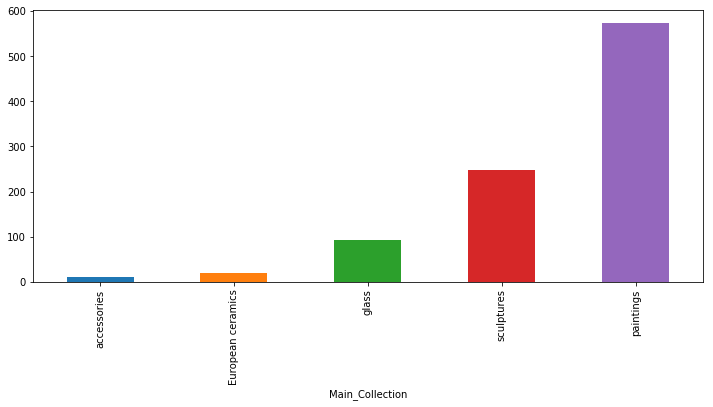

In [125]:
#6
df_2["Main_Collection"] = df_2["Collection"].map(lambda x: x[0])


fig = plt.figure(figsize = (12, 5))
df_2.groupby('Main_Collection')["objectNumber"].count().sort_values()[-5:].plot.bar(ylim=0)
plt.show();

## 5.  Preprocessing <a name="5"></a>

### Dataframe Preprocessing

We now have to clean our data - especifically the fields we will use for the analysis - "productionPlaces" and "Label".

We will first create a copy of our dataframe: this is so we can make changes to our place information without disrupting our original dataset. The copy will also filter out any rows that do not have either any label or origin information **(1)**

Now we can select the most relevant location of each row by creating a new column for the first element of the lists in each row's "productionPlaces" feature. **(2)** For our classifier model to work, we will also need to remove any rows with locations that have less than one occurrence. **(3)**

Finally, we will limit the number of columns in the dataset to the features essential to our analysis **(4)**.

In [154]:
#1
df_Places = df[(df["productionPlaces"].map(lambda x: len(x)) > 0) &
  (df["Label"].notnull())]

In [155]:
#2
df_Places["Place"] = df_Places["productionPlaces"].map(lambda x: x[0])

#3
df_Places = df_Places[df_Places.groupby("Place").objectNumber.transform(len) > 1]

#4
df_Places = df_Places[["objectNumber", "longTitle", "Label", "Place"]]


/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Let's quickly look at our new dataset - the one will will use for training and testing our models - to make sure the data is what we expected

In [159]:
df_Places.head()

,objectNumber,longTitle,Label,Place
AK-BR-JAN-1,AK-BR-JAN-1,"Shotoku Taishi, anonymous, c. 1200 - c. 1350",Buddhism took hold in Japan in the middle of t...,Japan
AK-C-2012-28,AK-C-2012-28,"Document case, anonymous, 1684 - 1692",This document case is a fine example of the ki...,Japan
AK-MAK-119,AK-MAK-119,"Seishi, anonymous, c. 1400 - c. 1600",The deity Seishi stands for wisdom and in Japa...,Japan
AK-MAK-12,AK-MAK-12,"Ornament for a shield, anonymous, c. -1100 - c...",Bronze human masks were affixed to shields as ...,China
AK-MAK-121,AK-MAK-121,"The Buddha Amida Nyorai, anonymous, c. 1500 - ...",This Buddha is holding his hands on his lap in...,Japan


### Text Preprocessing
Now we need to clean our string data by removing odd symbols or stopwords that might mess with the classifier's assessment. 

For this we need to initialize three sets of characters/words using [regular expressions][1]:
1. All punctuation that should be replaced in the string with a space **(1)**
2. All symbols that are not numbers or alphabetic chracters and should be removed completely - i.e. they should be replaced with nothing. **(2)**
3. All English words whose increased frequency in the language could interfere with the classifier's analysis. **(3)**

The function **clean_Text** takes strings and removes unnecessary characters/words in them that appear in the sets compiled above. **(4)** We can then use the function to create "clean" versions of the two features used in our analysis. **(5)**

*Note: for more information in regular expressions, their use and creation, please see the following [O'Reilly article][2] or [video tutorials][3].*

[1]: https://en.wikipedia.org/wiki/Regular_expression
[2]: https://www.oreilly.com/ideas/an-introduction-to-regular-expressions
[3]: https://www.youtube.com/watch?v=7DG3kCDx53c&list=PLRqwX-V7Uu6YEypLuls7iidwHMdCM6o2w

In [161]:
#1
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

#2
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

#3
STOPWORDS = set(stopwords.words('english'))

#4
def clean_Text(text):
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [162]:
#5
df_Places["Place"] = df_Places["Place"].apply(clean_Text)
df_Places["Label"] = df_Places["Label"].apply(clean_Text)

## 6. Feature Extraction <a name="6"></a>
With our data clean, we can transform it from raw text to features - a core step in any Natural Language Processing analysis.

First, **LabelEncoder** will transform categorical string data (our "Place" feature) into numerical values our model can understand - i.e. numbers between 0 and n-1, with n representing the total number of unique categories in our feature. **(1)**

Then, we use **fit_transform** with our encoded labels to transform our data according to the dataset's centered parameters. **(2)**

*Note: while a thorough explanation of the importance of fit_transform is outside the scope of this excercise, there are [online tutorials][1] and [forum posts][2] that go further into the function's relevance.*

**train_test_split** will randomly divide our dataset into training and testing subsets **(3)**:
* Training Set: labelled/tagged records; the classifier will study their features to learn how to best predict the different categories. 
* Test Set: unlabelled records; the classifier will try to predict their categories and then compare its predictions with each record's real label. 
* The output is hence 4 sets of data: the features for the training and testing subsets (X_train, X_test) as well as the labels/categories for the training and testing data (y_train, y_test). 

In this case, we are telling the function to split our data 90%/10% for the training and testing sets, respectively. 

Finally, we will extract an array describing the unique classes produced from our label encoding. This will be useful later when we need to point our machine learning models to the categories available for classification. **(4)**


[1]: https://www.youtube.com/watch?v=ENvSybznF_o
[2]:https://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models

In [163]:
#1
lbl_enc = preprocessing.LabelEncoder()

#2
y = lbl_enc.fit_transform(df_Places.Place.values)

#3
X_train, X_test, y_train, y_test = train_test_split(df_Places.Label, y, 
                                                    stratify = y, 
                                                    random_state = 42, test_size = 0.1)

In [164]:
#4
target_names = lbl_enc.classes_

## 7. Tf-idf <a name="7"></a>

### Term Vectorization

After preparing our label data, the final step before applying the models is to vectorize our "Label" data. 

Simply put, this will reinterpret each word in our corpus as a column represented by a unique number. Each Label can then be transformed as a row of integers, with each number representing the frequency of its column's word (the term frequency) in the label text. 

Here is a very simple example: the vector is the first graph, while the other two link each text's and word's key to their English counterpart.


Text_ID| 0 | 1 | 2 | 3 | 4 |
:--- | --- | --- | --- | --- | --- |
Ex1 | 1 | 0 | 1 | 1 | 0 |
Ex2 | 1 | 1 | 0 | 1 | 0 |
Ex3| 1 | 1 | 0 | 0 | 1 |
Ex4 | 1 | 0 | 1 | 0 | 1 |
Ex5 | 0 | 2 | 0 | 0 | 1 |

Word_ID| Word |
:--- | --- |
0 | "I" |
1 | "red" |
2| "blue" |
3 | "like" |
4 | "love" |

Text_ID| Sentence
:--- | --- |
Ex1 | "I like blue" |
Ex2 | "I like red" |
Ex3| "I love red" |
Ex4 | "I love blue" |
Ex5 | "Red love red" |


### TF-IDF: Basics
One of the most common methods of term vectorization is ["Term Frequency-Inverse Document Frequency" (TF-IDF)][1]. 
* Term Frequency (TF): measures how frequently a term occurs in a document. 
* TF(t): represents how we normalize each term frequency - *(Number of times term t appears in a document) / (Total number of terms in the document)*
* Inverse Document Frequency (IDF): measures how important a term is. For this, we weigh down frequent terms while scaling up the rare ones. 
* IDF(t): computes the weight of each term based on it's popularity accross all our documents/labels -  *log_e(Total number of documents / Number of documents with term t in it)*

For our program, we will instantiate a version of scikit learn's **TfidfVectorizer** function **(1)**. While it is always recommended to go through the [documentation][2] to properly understand the function's parameters, here is a quick overview of those we altered for our analysis:
* strip_accents='unicode', replace all accented unicode characters with their corresponding ASCII character.
* analyzer='word', define our feature type as words.
* token_pattern=r'\w{1,}', tokenize only words of 1 or more characters.
* ngram_range=(1, 3), specifies our features are made of [unigram, bigram, and trigram][3].
* use_idf=True, enables inverse-document-frequency reweighting.
* smooth_idf=True, prevents zero division for unseen words.
* sublinear_tf=True, regularization technique that squishes the data to a lower, common magnitude -> 1 + log(tf).
* stop_words='english', cleans the text for common, low-impact words to make way for more relevant words that are unique to the corpus.

After creating our TF-IDF instance, we can fit the features of our training and testing subsets to have a matrix of all the existing terms in our corpus. **(2)** 

It is then necessary to transform our arrays of label text: now each row  will contain an number associated to a row in our dataset, a unique integer number (representing an instance of a word in the row) and the word's associated importance score as calculated by TF-IDF. **(3)** 

For a visual representation of these last steps, see the following [article][4].


[1]: https://en.wikipedia.org/wiki/Tf–idf
[2]: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
[3]: https://en.wikipedia.org/wiki/N-gram
[4]: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34


In [165]:
#1
tfidf = TfidfVectorizer(strip_accents = "unicode", analyzer = "word",
                       token_pattern = r'\w{1,}', ngram_range = (1, 3),
                       use_idf= True, smooth_idf = True,
                       sublinear_tf = True, 
                       stop_words = 'english')

#2
tfidf.fit(list(X_train) + list(X_test))

#3
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## 8. Naive Bayes + Tf-idf <a name="8"></a>

**Naive Bayes**: classifier based on Bayes' theorem that assumes the presence of a feature (in this case, a word in a label) in a class (the object's place of origin) is unrelated to other features. It is primarily used for text classification with high dimensional training data sets - such as our TF-IDF matrix. 

There are many variations of the Naive Bayes algorithm (which you can read about [here][1]). In this case, we will use the [multinomial variation][2] where multiple occurrences of a feature have a high impact on the output.

For our analysis, we must first initialize a version of the algorithm. **(1)** We can then "fit" our training data (X-train_tfidf) and its labels (y_train) into the algorithm - this gives the model our previously-labelled features to study in order to make its category predictions. **(2)**

We can then present the full results from the model using **classification_report**. **(3)** Skip to Section 10 for the interpretation of these results. 

[1]: https://www.hackerearth.com/blog/machine-learning/introduction-naive-bayes-algorithm-codes-python-r/
[2]: https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

In [166]:
#1
NBclf = MultinomialNB()

#2
NBclf.fit(X_train_tfidf, y_train)
y_pred = NBclf.predict(X_test_tfidf)

#3
print("---NB Test Set Results---")
print("Accuracy with NB: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))


---NB Test Set Results---
Accuracy with NB: 0.4859154929577465
                        precision    recall  f1-score   support

             amsterdam       0.22      1.00      0.36        20
               antwerp       0.00      0.00      0.00         3
                arnhem       0.00      0.00      0.00         1
              augsburg       0.00      0.00      0.00         2
               austria       1.00      1.00      1.00         2
               batavia       0.00      0.00      0.00         2
                berlin       0.00      0.00      0.00         2
            birmingham       1.00      0.20      0.33         5
                bruges       1.00      0.75      0.86        12
              brussels       1.00      1.00      1.00         1
                 china       1.00      0.20      0.33         5
                 delft       0.00      0.00      0.00         1
            den helder       0.00      0.00      0.00         2
              deventer       1.00      0

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 35, does not match size of target_names, 51
  .format(len(labels), len(target_names))
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 9. Random Forest + Tf-idf <a name="9"></a>
**Random Forest**: classifier that creates a series - "forest" - of [Decision Trees][1] whose results are then merged to create a more stable, accurate prediction. The algorithm considers a random subset of features with every new tree, ensuring greater feature diversity and overall a better model. Random Forest can work with both classification and regression machine learning problems. 

See the following [link][2] for a thorough explanation of the model's structure, importance and use cases.

The steps to apply the Random Forest classifier are the same as those for Naive Bayes: initializing the model **(1)**, fitting it with the data **(2)** and presenting the results. **(3)**

[1]: https://en.wikipedia.org/wiki/Decision_tree#Decision_tree_building_blocks
[2]: https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd

In [167]:
#1
RFclf = RandomForestClassifier()

#2
RFclf.fit(X_train_tfidf, y_train)
y_pred = RFclf.predict(X_test_tfidf)

#3
print("---Test Set Results---")
print("Accuracy with RF: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with RF: 0.6126760563380281
                        precision    recall  f1-score   support

             amsterdam       0.35      0.85      0.50        20
               antwerp       0.67      0.67      0.67         3
                arnhem       0.00      0.00      0.00         1
              augsburg       0.50      0.50      0.50         2
               austria       1.00      1.00      1.00         2
               batavia       0.67      1.00      0.80         2
                berlin       0.00      0.00      0.00         2
            birmingham       0.75      0.60      0.67         5
                bruges       1.00      0.75      0.86        12
              brussels       0.50      1.00      0.67         1
                 china       1.00      0.80      0.89         5
                 delft       0.00      0.00      0.00         1
            den helder       0.00      0.00      0.00         2
              deventer       0.60      0.50

/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 35, does not match size of target_names, 51
  .format(len(labels), len(target_names))
/Users/andres/anaconda/envs/Py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 10. Comparing Results & Improving the Model <a name="10"></a>

### Metrics
* [Accuracy][1]: the percentage of predictions our model got right. 
    - Ex. if our model had an accuracy of .65, it correctly classified 65% of all records. 
* [Precision][2]: the proportion of positive identifications in our model that were correct; calculated as the number of True Positives over Total (True and False) Positives. 
    - Ex. if the category "amsterdam" had a precision of 0.29, it means that, out of all the records our model labelled as "amsterdam", only 29% were correct. 
* [Recall][2]: the proportion of labels that were identified correctly. In other words how many examples of a certain label were accurately predicted vs. how many were missed. 
    - Ex. if the category "hague" had a recall score of 0.33, it means that, out of all the records labelled "hague", our model correctly identified 33% of said records, but missed 77% of them. 
* [F-1 Score][3]: the weighted harmonic mean of our models' precision and recall value - i.e. it conveys the balance between the model's precision and recall metrics. 
* [Support][4]: number of records for each class (or the entire subset) in the tested dataset. 

*Note: visit scikit-learn's [documentation][5] for a detailed description of all available statistics.*

[1]: https://developers.google.com/machine-learning/crash-course/classification/accuracy
[2]: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
[3]: https://en.wikipedia.org/wiki/F1_score
[4]: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
[5]: https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures

### Interpreting Results 

The table below puts together the basic prediction statistics from our models: 

Statistic | NaiveB | RandomF
:--- | --- | ---
*Accuracy* | 0.486 | 0.613
*Avg. Precision* | 0.61 | 0.63
*Avg. Recall* | 0.49 | 0.61
*Avg. F-1 Score* | 0.46 | 0.60
*Support* | 142 | 142

Based on these results, our Random Forest produced more accurate predictions on the origin locations of our objects, although not by much. While the metric criteria for a succesful model depends on each project, one should always [consider many different available metrics][1] before making any business decisions based on the algorithm's results. 

### Improving the Model & Results

For best results, always try to...
* ...gather as much training data as possible! 
    - With approximately 2000 records to train and test our model, our excercise was on the lower end of the size spectrum. 
* ...conduct more text pre-processing, like [stemming or lemmatization][1]
    - This can help the model give words like "sculpture", "sculpting" and "sculptor" equal weight in its analysis. 
* ...experiment with and compare different models according to your machine learning problem. 
    - For this excercise, we could have also looked into algorithms like [Support Vector Classifier][2], [Logistic Regression][3] or [Xgboost][4]. 
    - Remember to look into each model's advantages and disadvantages in regards to your data's or inquiry's characteristics.

[1]: https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b
[2]: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
[3]: https://scikit-learn.org/stable/modules/svm.html#classification
[4]: https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102
[5]: https://xgboost.readthedocs.io/en/latest/python/python_api.html



## 11. Conclusion <a name="11"></a>

Implementing machine learning technologies (especially in new sectors) will always be an iterative, exploratory process: AI-based models, implementations and products must depend on extensive brainstorming and testing in order to be succesful.

Even though the first iteration of our models was not (numerically) successful, it is important to remember that there is always room for improvement and innovation. Ideally, after this initial set of results, we would continue studying both the data and the algorithms to look for ways in which to refine the model and its subsequent implementation. 

Do not be afraid to consider questions like...
* ...are we looking at the wrong dependent variable and should instead seek to predict object iconography tags?
* ...are we asking the wrong question: should we reconfigure our analysis as a regression excercise? 
* ...do we need to collect more data (either from our own collection or a partner institution)? 

Regardless of the inquiry, always [make sure the technology follows both the museum's vision and its audience's needs][1] - not the other way around. Machine learning's possibilities are endless, so [guide your AI solutions according to your institution's requirements][2] in order to create valuable experiences for staff and visitors alike. Otherwise, without the human component, your models will only be numbers on a spreadsheet or lines in a function.

[1]: https://strategyn.com/outcome-driven-innovation-process/customer-needs/
[2]: https://www.huffingtonpost.com/entry/is-your-companys-reaction-to-digital-a-cacophony-or_us_5a31a70ee4b04bd8793e970d
